# Data Understanding – Online Retail Dataset

## Objective
The goal of this notebook is to understand the structure, scale, and characteristics
of the Online Retail transactional dataset. This includes:
- Dataset schema
- Transaction and basket structure
- Temporal coverage
- Initial business insights relevant to product bundle recommendation

No data cleaning or modeling is performed in this notebook.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

sns.set_style("whitegrid")

In [36]:
BASE_DIR = Path().resolve().parent
DATA_FILE = BASE_DIR / "data" / "data.csv"

print("Loading data from:", DATA_FILE)

df = pd.read_csv(
    DATA_FILE,
    encoding="ISO-8859-1"
)


Loading data from: D:\Code Playground\ML_Ops\product-bundle-recommender-system\data\data.csv


In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


In [38]:
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 541,909
Number of columns: 8


In [ ]:
df.memory_usage(deep=True).sum() / 1024**2 # total memory usage of the DataFrame in megabytes (MB), including the index and deeply introspected objects

np.float64(173.12356662750244)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Column Descriptions

- InvoiceNo: Unique identifier for each order (basket)
- StockCode: Unique product identifier
- Description: Product description
- Quantity: Number of units purchased
- InvoiceDate: Timestamp of transaction
- UnitPrice: Price per unit
- CustomerID: Unique customer identifier
- Country: Customer’s country


In [41]:
missing_summary = (
    df.isna()
      .sum()
      .to_frame("missing_count")
      .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
      .sort_values("missing_pct", ascending=False)
)

missing_summary

,missing_count,missing_pct
CustomerID,135080,24.93
Description,1454,0.27
StockCode,0,0.00
InvoiceNo,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
Country,0,0.00


In [51]:
df.describe(include="number").T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
UnitPrice,541909.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
CustomerID,406829.00,15287.69,1713.60,12346.00,13953.00,15152.00,16791.00,18287.00


In [44]:
summary_counts = {
    "Unique Orders (InvoiceNo)": df["InvoiceNo"].nunique(),
    "Unique Products (StockCode)": df["StockCode"].nunique(),
    "Unique Customers": df["CustomerID"].nunique(),
    "Countries": df["Country"].nunique()
}

pd.Series(summary_counts)

Unique Orders (InvoiceNo)      25900
Unique Products (StockCode)     4070
Unique Customers                4372
Countries                         38
dtype: int64

In [45]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["InvoiceDate"].min(), df["InvoiceDate"].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [ ]:
# Calculates basket sizes per invoice and then summarizes their distribution. It tells you how many items customers usually buy, how variable basket sizes are.
basket_sizes = (
    df.groupby("InvoiceNo")["StockCode"]
      .count()
)

basket_sizes.describe()

count   25900.00
mean       20.92
std        43.03
min         1.00
25%         2.00
50%        10.00
75%        23.00
max      1114.00
Name: StockCode, dtype: float64

In [58]:
basket_sizes.shape, basket_sizes.head()

((25900,),
 InvoiceNo
 536365     7
 536366     2
 536367    12
 536368     4
 536369     1
 Name: StockCode, dtype: int64)

In [62]:
basket_sizes.value_counts().head(10)

StockCode
1     5841
2     1612
3     1095
4      815
5      788
6      670
7      652
8      631
9      629
11     573
Name: count, dtype: int64

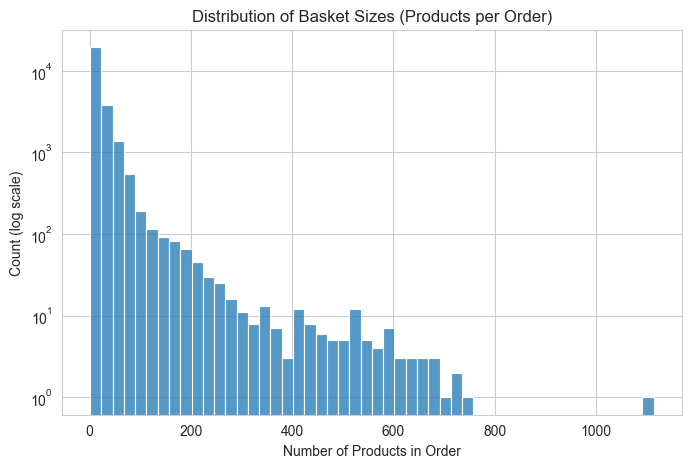

In [66]:
plt.figure(figsize=(8, 5))
sns.histplot(basket_sizes, bins=50)
plt.yscale("log")
plt.title("Distribution of Basket Sizes (Products per Order)")
plt.xlabel("Number of Products in Order")
plt.ylabel("Count (log scale)")
plt.show()

In [67]:
top_products = (
    df.groupby("Description")["Quantity"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top_products

Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
JUMBO BAG RED RETROSPOT               47363
ASSORTED COLOUR BIRD ORNAMENT         36381
POPCORN HOLDER                        36334
PACK OF 72 RETROSPOT CAKE CASES       36039
WHITE HANGING HEART T-LIGHT HOLDER    35317
RABBIT NIGHT LIGHT                    30680
MINI PAINT SET VINTAGE                26437
PACK OF 12 LONDON TISSUES             26315
PACK OF 60 PINK PAISLEY CAKE CASES    24753
Name: Quantity, dtype: int64

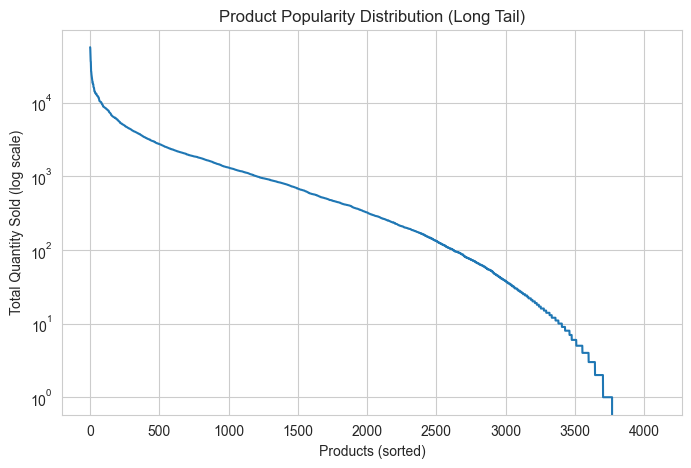

In [68]:
product_popularity = (
    df.groupby("StockCode")["Quantity"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
plt.plot(product_popularity.values)
plt.yscale("log")
plt.title("Product Popularity Distribution (Long Tail)")
plt.xlabel("Products (sorted)")
plt.ylabel("Total Quantity Sold (log scale)")
plt.show()


In [70]:
df["Country"].value_counts().head(10)

Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64

## Key Observations

- The dataset represents real transactional e-commerce data.
- Orders typically contain multiple products, making it suitable for bundle analysis.
- Product popularity follows a long-tail distribution.
- Significant missing values exist in CustomerID, which will require handling later.
- Temporal coverage spans multiple months, enabling time-aware modeling.

This dataset is appropriate for building a production-style product bundle recommender.
